In [4]:
import pandas as pd
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import curve_fit
import itertools
from sklearn.metrics import mean_squared_log_error

from utils.model import hill_activation, hill_activation_single, hill_activation_and, random_search#, hill_activation_ymin_ymax
from utils.helper import generate_data_at_t, \
                       get_blank_corrected, get_neg_ctrl_corrected, get_pos_ctrl_corrected, \
                       generate_data, setup_header, read_map
from utils.plotter import plot_heatmap

In [2]:
with open('utils/hill-params.json', 'r') as f:
    HILL_PARAMS = json.load(f)
HILL_PARAMS

{'PBAD': [0.52, -0.06, 0.15, -2.07],
 'PCin': [-0.32, 0.91, 0.29, -3.11],
 'PSalTTC': [-0.46, 1.76, 0.29, -1.71],
 'e20': [0.38, -2.05, -0.03, -1.64],
 'e38': [0.02, -1.53, -0.1, -1.99]}

#### Induction matrix 2-input AND gates

Generate data.

In [5]:
folder = '053-E20-E38-induction-matrix'
aras = [0.05078125/4, 0.05078125, 0.203125, 0.8125, 3.25, 13]
ohc14s = [0.078125/4, 0.078125, 0.3125, 1.25, 5, 20]
inducers = [aras, ohc14s]
samples_t = generate_data_at_t(folder, 'raw', 'plate_map', kind='2-input induction matrix', pos_ctrl_map=[(0, 2), (1, 2)])

[('A', 'sample'), ('B', 'sample'), ('C', 'positive')]


#### E20 & E38

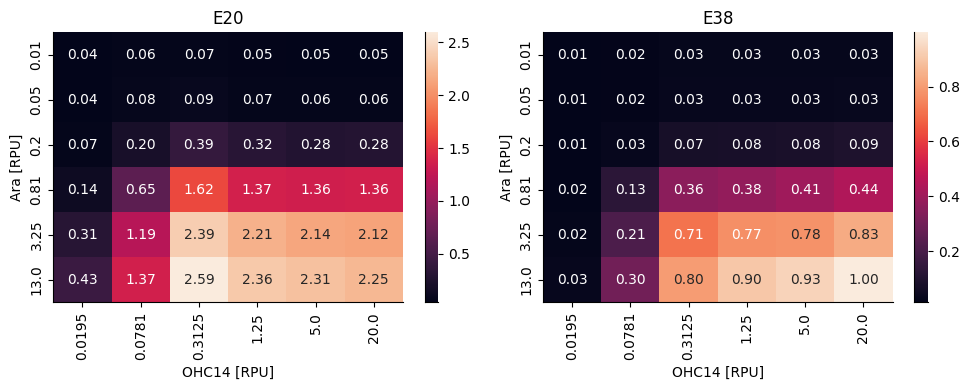

In [7]:
f, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 4))
axr = axs.ravel()

fluo_t = samples_t[0].reset_index()
fluo_t['ara'] = (fluo_t['name'].str.split('_', expand=True)[1].str[0]).astype(int)
fluo_t['ara'] = fluo_t['ara'].apply(lambda x: aras[x])
fluo_t['ohc14'] = (fluo_t['name'].str.split('_', expand=True)[1].str[1]).astype(int)
fluo_t['ohc14'] = fluo_t['ohc14'].apply(lambda x: ohc14s[x])
actual = fluo_t[['8 h ', 'ara', 'ohc14']].pivot('ara', 'ohc14')
actual.index = [np.round(i, 2) for i in aras]
actual.columns = [np.round(i, 4) for i in ohc14s]
sns.heatmap(actual, annot=True, fmt='.2f', ax=axr[0])
axr[0].set_xlabel('OHC14 [RPU]')
axr[0].set_ylabel('Ara [RPU]')
axr[0].set_title('E20')

fluo_t = samples_t[1].reset_index()
fluo_t['ara'] = (fluo_t['name'].str.split('_', expand=True)[1].str[0]).astype(int)
fluo_t['ara'] = fluo_t['ara'].apply(lambda x: aras[x])
fluo_t['ohc14'] = (fluo_t['name'].str.split('_', expand=True)[1].str[1]).astype(int)
fluo_t['ohc14'] = fluo_t['ohc14'].apply(lambda x: ohc14s[x])
actual = fluo_t[['8 h ', 'ara', 'ohc14']].pivot('ara', 'ohc14')
actual.index = [np.round(i, 2) for i in aras]
actual.columns = [np.round(i, 4) for i in ohc14s]
sns.heatmap(actual, annot=True, fmt='.2f', ax=axr[1])
axr[1].set_xlabel('OHC14 [RPU]')
axr[1].set_ylabel('Ara [RPU]')
axr[1].set_title('E38')

plt.tight_layout()
sns.despine()

In [10]:
fluo_t = samples_t[0].reset_index()
fluo_t['ara'] = (fluo_t['name'].str.split('_', expand=True)[1].str[0]).astype(int)
fluo_t['ara'] = fluo_t['ara'].apply(lambda x: aras[x])
fluo_t['ohc14'] = (fluo_t['name'].str.split('_', expand=True)[1].str[1]).astype(int)
fluo_t['ohc14'] = fluo_t['ohc14'].apply(lambda x: ohc14s[x])

In [9]:
x2, x1 = np.meshgrid(ohc14s, aras)
x = np.vstack((x2.ravel(), x1.ravel()))
y = np.abs(fluo_t['8 h '].values)

In [ ]:
#gate_bounds = [[0, -3, -2, -3, -2, 0, -15, 0, 0, -12],
#               [1, 0, 0, -1, 0, 2, -1, 2, 1, 0]]
gate_bounds = [[0, -3, -2, -3],
               [1, 0, 0, -1]]
init_guess = random_search(50, x, y, gate_bounds, hill_activation_and)
popt, pcov = curve_fit(hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds)
popt

In [11]:
popt = HILL_PARAMS['e20'] + HILL_PARAMS['PBAD'][1:] + HILL_PARAMS['PCin'][1:]
fluo_t['pred'] = hill_activation_and(x, *popt)

In [12]:
actual = fluo_t[['8 h ', 'ara', 'ohc14']].pivot('ara', 'ohc14')
actual.index = [np.round(i, 2) for i in aras]
actual.columns = [np.round(i, 4) for i in ohc14s]

training = fluo_t[['pred', 'ara', 'ohc14']].pivot('ara', 'ohc14')
training.index = [np.round(i, 2) for i in aras]
training.columns = [np.round(i, 4) for i in ohc14s]

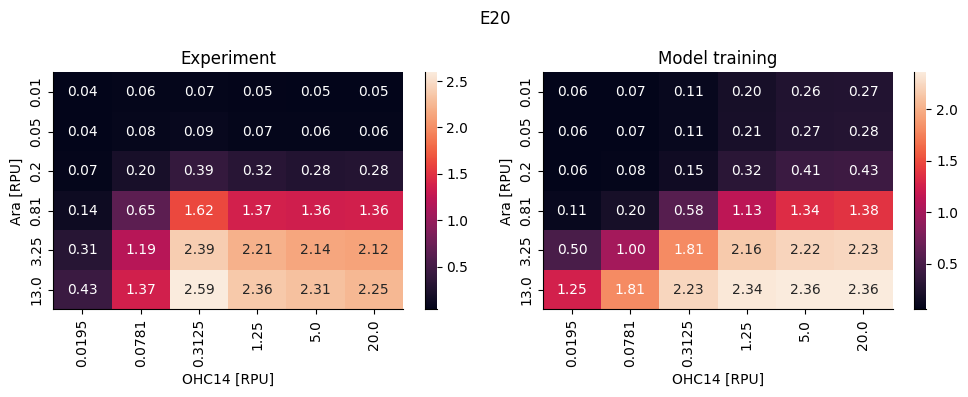

In [13]:
f, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 4))
axr = axs.ravel()
sns.heatmap(actual, annot=True, fmt='.2f', ax=axr[0])
axr[0].set_xlabel('OHC14 [RPU]')
axr[0].set_ylabel('Ara [RPU]')
axr[0].set_title('Experiment')

sns.heatmap(training, annot=True, fmt='.2f', ax=axr[1])
axr[1].set_xlabel('OHC14 [RPU]')
axr[1].set_ylabel('Ara [RPU]')
axr[1].set_title('Model training')

plt.suptitle('E20')
plt.tight_layout()
sns.despine()

In [14]:
actual = fluo_t[['8 h ', 'ara', 'ohc14']].pivot('ara', 'ohc14')
actual.index = aras #[np.round(i, 2) for i in aras_rpu]
actual.columns = ohc14s #[np.round(i, 2) for i in ohc14s_rpu]

training = fluo_t[['pred', 'ara', 'ohc14']].pivot('ara', 'ohc14')
training.index = aras #[np.round(i, 2) for i in aras_rpu]
training.columns = ohc14s #[np.round(i, 2) for i in ohc14s_rpu]

#### Visualization

In [15]:
colors = ['#cc0000', '#00cc00', '#0000cc', '#cccc00', '#cc00cc', '#00cccc']

In [17]:
aras_lim = np.log10(min(aras)/2), np.log10(max(aras)*2)
ohc14s_lim = np.log10(min(ohc14s)/2), np.log10(max(ohc14s)*2)
ind1 = np.logspace(*aras_lim, 100)
ind2 = np.logspace(*ohc14s_lim, 100)

In [18]:
x2, x1 = np.meshgrid(ind2, aras)
x = np.vstack((x2.ravel(), x1.ravel()))
y_pred = hill_activation_and(x, *popt)
df = pd.DataFrame(x.T)
df['y'] = y_pred
training = df.pivot(1, 0)
training.index = aras
training.columns = ind2

[0.38, -2.05, -0.03, -1.64, -0.06, 0.15, -2.07, 0.91, 0.29, -3.11]


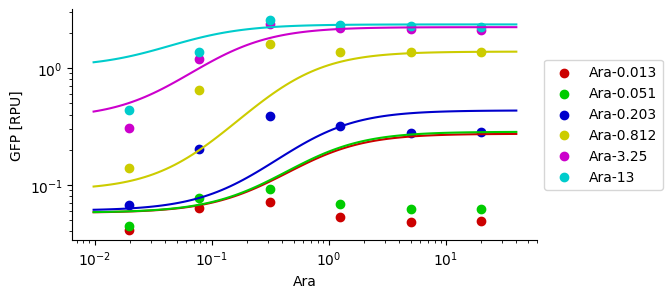

In [19]:
plt.figure(figsize=[6, 3])
print(popt)
for i in range(len(actual)):
    plt.scatter(actual.columns, actual.iloc[i, :], color=colors[i], label='Ara-{}'.format(np.round(aras[i], 3)))
    plt.plot(training.columns, training.iloc[i, :], color=colors[i])
plt.loglog()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('GFP [RPU]')
plt.xlabel('Ara')
sns.despine()

In [20]:
x2_, x1_ = np.meshgrid(ohc14s, ind1)
x_ = np.vstack((x2_.ravel(), x1_.ravel()))
y_pred_ = hill_activation_and(x_, *popt)
df_ = pd.DataFrame(x_.T)
df_['y'] = y_pred_
training_ = df_.pivot(1, 0)
training_.index = ind1
training_.columns = ohc14s

[0.38, -2.05, -0.03, -1.64, -0.06, 0.15, -2.07, 0.91, 0.29, -3.11]


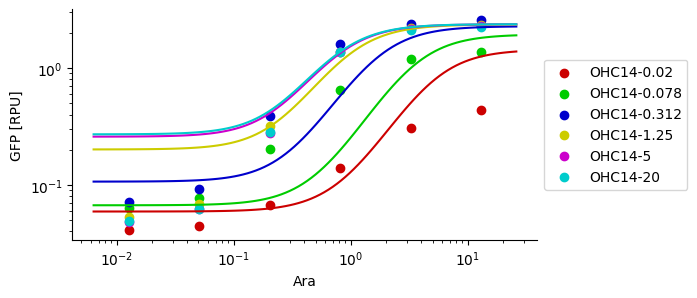

In [21]:
plt.figure(figsize=[6, 3])
print(popt)
for i in range(len(actual.columns)):
    plt.scatter(actual.index, actual.iloc[:, i], color=colors[i], label='OHC14-{}'.format(np.round(ohc14s[i], 3)))
    plt.plot(training_.index, training_.iloc[:, i], color=colors[i])
plt.loglog()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('GFP [RPU]')
plt.xlabel('Ara')
sns.despine()

#### 3-input AND gate

In [22]:
def hill_activation_and_3(x):

    x1, x2, x3 = x
    
    agi1, Ki1, ni1, epsi1 = HILL_PARAMS['PBAD']
    agi2, Ki2, ni2, epsi2 = HILL_PARAMS['PCin']
    agi3, Ki3, ni3, epsi3 = HILL_PARAMS['PSalTTC']
    ag1, K1, n1, eps1 = HILL_PARAMS['e38']
    ag2, K2, n2, eps2 = HILL_PARAMS['e20']
    
    inner_hill = hill_activation(hill_activation(x1, Ki1, ni1, epsi1)*hill_activation(x2, Ki2, ni2, epsi2), K1, n1, eps1)
    return 10**ag2 * hill_activation(inner_hill*hill_activation(x3, Ki3, ni3, epsi3), K2, n2, eps2)

In [25]:
aras = [0.8125/4, 0.8125, 3.25, 13]
ohc14s = [2.5/2, 2.5, 5, 10]
sals = [25/2, 25, 50, 100]
inducers = [aras, ohc14s, sals]
x = pd.DataFrame(itertools.product(*inducers)).T.values

circuit = pd.read_csv('datasets/experiment/900-cleansed/3i-and-gates-jump.csv')
y = circuit['e38-e20'].values

In [26]:
pred = pd.concat([pd.DataFrame(itertools.product(*inducers)), pd.DataFrame(hill_activation_and_3(x))], axis=1)
pred.columns = ['ara', 'ohc14', 'sal', 'prediction']
pred['actual'] = y

In [51]:
pred

,ara,ohc14,sal,prediction,actual
0,0.203125,1.25,12.5,1.305390,0.021430
1,0.203125,1.25,25.0,1.795687,0.076855
2,0.203125,1.25,50.0,2.092971,0.061890
3,0.203125,1.25,100.0,2.201943,0.078630
4,0.203125,2.50,12.5,1.685275,0.061999
...,...,...,...,...,...
59,13.000000,5.00,100.0,2.356377,2.101320
60,13.000000,10.00,12.5,2.066603,0.260399
61,13.000000,10.00,25.0,2.254870,0.856389
62,13.000000,10.00,50.0,2.334228,1.384702


In [45]:
def plot_3i_responses(data, inds, inds_lbl, row=2, col=2, xlabel='RPU', ylabel='GFP'):
    
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(inds[0]):
            y = data[data[inds_lbl[0]]==inds[0][i]]
            for j, o in enumerate(inds[1]):
                d = y[y[inds_lbl[1]]==o]
                ax.scatter(d[inds_lbl[2]], d['actual'])
                ax.plot(d[inds_lbl[2]], d['prediction'], label='{}-{}'.format(inds_lbl[1], inds[1][j]))
            ax.set_xlabel(inds_lbl[2])
            ax.set_ylabel(ylabel)
            ax.loglog()
            ax.set_title('{}-{}'.format(inds_lbl[0], inds[0][i]))
            ax.legend()
        else:
            ax.set_visible(False)
    plt.tight_layout()
    sns.despine()

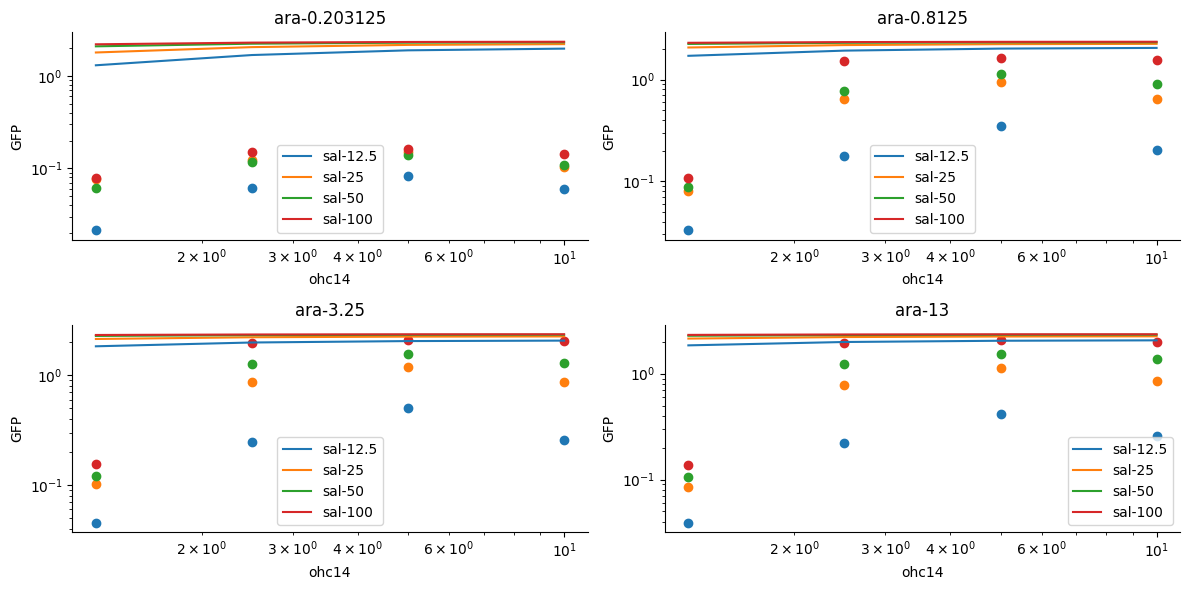

In [53]:
plot_3i_responses(pred, [aras, sals, ohc14s], ['ara', 'sal', 'ohc14'])

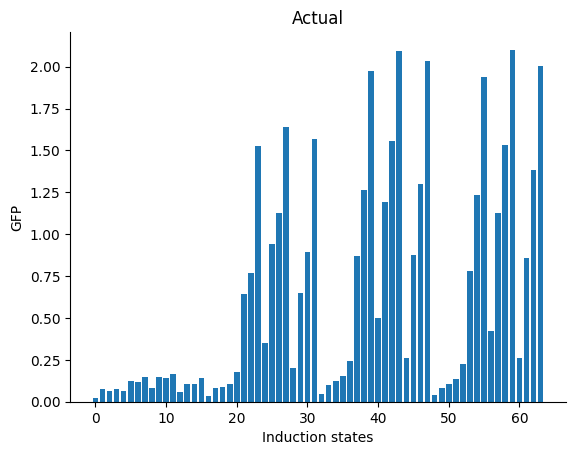

In [49]:
df = pd.DataFrame([(a, b) for a, b in zip(y, hill_activation_and_3(pd.DataFrame(itertools.product(*inducers)).T.values))])
plt.bar(df.index, df[0])
plt.title('Actual')
plt.ylabel('GFP')
plt.xlabel('Induction states')
sns.despine()

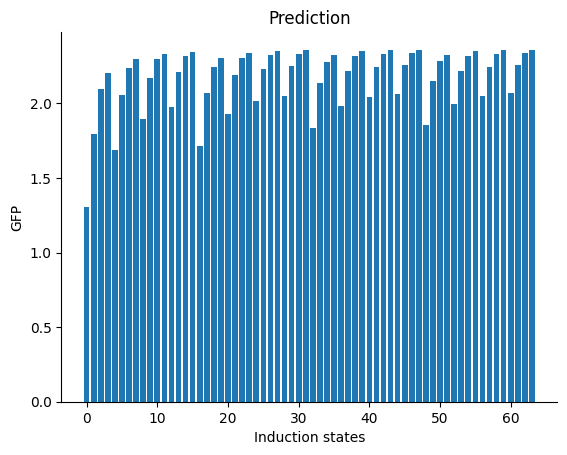

In [50]:
plt.bar(df.index, df[1])
plt.title('Prediction')
plt.ylabel('GFP')
plt.xlabel('Induction states')
sns.despine()